In [1]:
import paho.mqtt.client as paho
from IPython.display import display, clear_output, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
HIGH = 30
GRAPH_HEIGHT = 4 + 2 + 4
Y_LIMIT = HIGH + 4
Y_BOTTOM = HIGH - 6
Y_TICK_INTERVAL = 2
X_LIMIT = 1000
DATA_SIZE = X_LIMIT
INFO_TOP = Y_LIMIT - 0.4
GRAPH_H = 7
GRAPH_W = 14

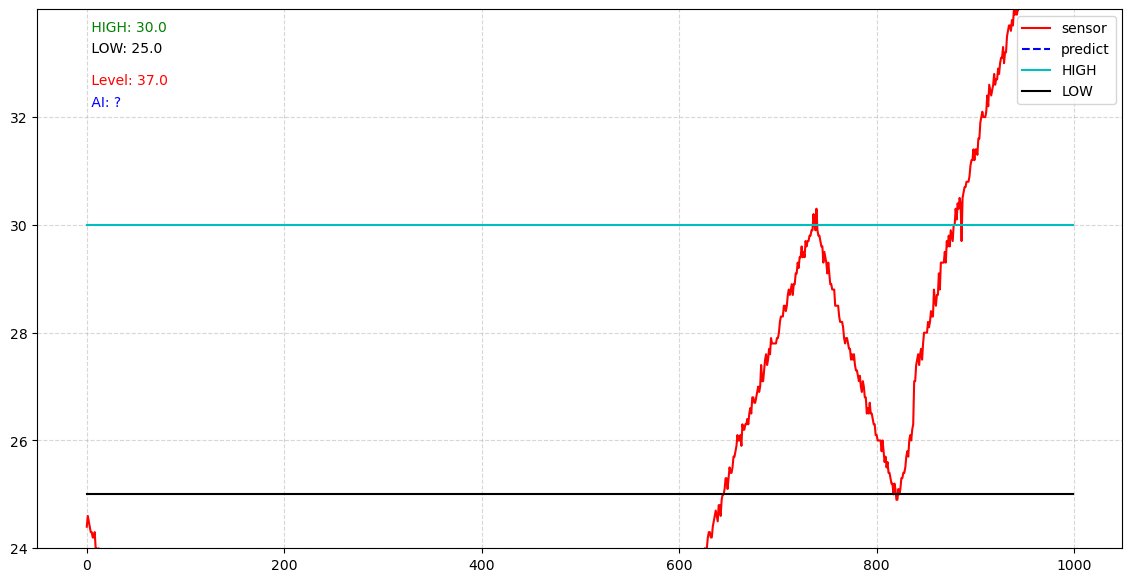

In [ ]:
ytick = [t*Y_TICK_INTERVAL+Y_BOTTOM for t in range((Y_LIMIT-Y_BOTTOM+1)//Y_TICK_INTERVAL)]
ylabel = [str(t) for t in ytick]

fig = plt.figure(figsize=(GRAPH_W, GRAPH_H))
ax = fig.add_subplot(111)
ax.set_ylim([Y_BOTTOM,Y_LIMIT])
ax.set_yticks(ytick, ylabel)
plt.grid(True, alpha=0.5, linestyle='--')

data_size = DATA_SIZE
data={'LEVEL_SENSOR':[-1 for i in range(data_size)], 
      'LEVEL_AI':[-1 for i in range(data_size)],
      'SETTING_LOW':[-1 for i in range(data_size)],
      'SETTING_HIGH':[-1 for i in range(data_size)]
     }

initial_draw = True

def on_message(mosq, obj, msg):
    global initial_draw
    
    for k, v in data.items():
        data[k] = data[k][1:]

    ml = msg.payload.decode('utf-8')
    ml = ml.split(' ')
    
    data['LEVEL_SENSOR'].append(float(ml[0]))
    data['LEVEL_AI'].append(float(ml[1]))
    data['SETTING_LOW'].append(float(ml[2]))
    data['SETTING_HIGH'].append(float(ml[3]))
    
    if initial_draw:
        data['SETTING_LOW'] = [data['SETTING_LOW'][-1] for _ in data['SETTING_LOW']]
        data['SETTING_HIGH'] = [data['SETTING_HIGH'][-1] for _ in data['SETTING_HIGH']]
        initial_draw=False
        
    mosq.publish('pong', 'ack', 0)
    ax.clear()
    ax.set_ylim([Y_BOTTOM, Y_LIMIT])
    ax.set_yticks(ytick, ylabel)
    plt.grid(True, alpha=0.5, linestyle='--')

    ax.plot(data['LEVEL_SENSOR'],'r', label='sensor')
    ax.plot(data['LEVEL_AI'],'b--', label='predict')
    ax.plot(data['SETTING_HIGH'], 'c-', label='HIGH')    
    ax.plot(data['SETTING_LOW'], 'k-', label='LOW')
    plt.legend(loc='upper right')
    
    sv = data['LEVEL_SENSOR'][-1]
    if sv<0:
        sv = '?' 
    sa = data['LEVEL_AI'][-1]
    if sa<0:
        sa = '?'
        
    plt.text(0,INFO_TOP,f" HIGH: {data['SETTING_HIGH'][-1]}", color='green')
    plt.text(0,INFO_TOP-0.4,f" LOW: {data['SETTING_LOW'][-1]}", color='black')        
    plt.text(0,INFO_TOP-1.0,f" Level: {sv}", color="red")
    plt.text(0,INFO_TOP-1.4,f" AI: {sa}", color="blue")
    
    display(fig)
    clear_output(wait=True)
    #plt.pause(0.2)

def on_publish(mosq, obj, mid):
    pass

client = paho.Client('jupyter')
client.on_message = on_message
client.on_publish = on_publish

client.connect("127.0.0.1", 1883, 60)

client.subscribe("TOPIC_PUMP", 0)

while client.loop() == 0:
    pass
